# Traduction de texte

In [1]:
import os
import re
import string

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model, callbacks, layers, backend as K
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.losses import sparse_categorical_crossentropy

from unicodedata import normalize
from collections import Counter

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


<hr>

## Fonctions

In [30]:
def load_doc(filename):
    file = open(filename, mode='rt', encoding='utf-8')
    text = file.read()
    file.close()
    return text.strip()


def sentence_length(sentences):
    lengths = [len(s.split()) for s in sentences]
    return max(lengths)


def get_vocab(lines):
    vocab = Counter()
    for line in lines:
        tokens = line.split()
        vocab.update(tokens)
    return vocab


def create_dico(vocab):
    liste_mot = [k for k in vocab.keys()] + ['unk']
    dico_ch2int = {mot: i + 1 for i, mot in enumerate(liste_mot)}
    dico_int2ch = {idx: mot for mot, idx in dico_ch2int.items()}
    return dico_ch2int, dico_int2ch

def decode_prediction(input_seq, encod_model, decod_model, int2ch, max_decoder_seq_length, index_bos_word):
    states_value = encod_model.predict(input_seq)
    target_seq = np.zeros((1, max_decoder_seq_length))
    target_seq[0,0] = index_bos_word
    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        output_tokens, h, c = decod_model.predict([target_seq] + states_value)
        print(output_tokens.shape)
        
        token_index = np.argmax(output_tokens[0, 0, 1:]) +1
        print(token_index)

        pred_word = int2ch[token_index]
        decoded_sentence += pred_word +' '
        print(pred_word)

        if (pred_word == 'eos' or len(decoded_sentence.split(' ')) > max_decoder_seq_length):
            stop_condition = True
            
        target_seq = np.zeros((1, max_decoder_seq_length))
        target_seq[0, 0] = token_index
        states_value = [h, c]

    return decoded_sentence

In [4]:
path_to_zip = tf.keras.utils.get_file(
    'fr-en.tgz',
    origin='https://www.statmt.org/europarl/v7/fr-en.tgz',
    extract=True)
print(path_to_zip)
path_to_file = os.path.dirname(path_to_zip)

texte_fr = load_doc(path_to_file + '/europarl-v7.fr-en.fr')
texte_en = load_doc(path_to_file + '/europarl-v7.fr-en.en')

C:\Users\SIGMA\.keras\datasets\fr-en.tgz


# Préparation des données
Les données sont des discours traduits en français et en anglais issus du parlement européen.

## Preprocessing de base
Ecrire une fonction `text_to_sentences` qui découpe le texte (sortie de la fonction `load_doc`) en phrases (liste de chaînes de caractères).  
Cette fonction ajoutera le mot `EOS` ("EndOfSentence") à la fin de chaque phrase.  
Afficher le nombre de phrases et les 5 premières phrases en français

In [5]:
def text_to_sentences(text):
    sentences = text.split('\n')
    return list(map(lambda x:x+' EOS', sentences))

In [6]:
sent_en = text_to_sentences(texte_en)
sent_fr = text_to_sentences(texte_fr)
sent_fr[:5]

['Reprise de la session EOS',
 'Je déclare reprise la session du Parlement européen qui avait été interrompue le vendredi 17 décembre dernier et je vous renouvelle tous mes vux en espérant que vous avez passé de bonnes vacances. EOS',
 'Comme vous avez pu le constater, le grand "bogue de l\'an 2000" ne s\'est pas produit. En revanche, les citoyens d\'un certain nombre de nos pays ont été victimes de catastrophes naturelles qui ont vraiment été terribles. EOS',
 'Vous avez souhaité un débat à ce sujet dans les prochains jours, au cours de cette période de session. EOS',
 "En attendant, je souhaiterais, comme un certain nombre de collègues me l'ont demandé, que nous observions une minute de silence pour toutes les victimes, des tempêtes notamment, dans les différents pays de l'Union européenne qui ont été touchés. EOS"]

Appliquer la fonction `sentence_length` sur les textes français et anglais.  
Cette fonction retourne la longueur de la phrase la plus longue dans un texte.  Afficher le résultat pour chacun des 2 textes.

In [7]:
sentence_length(sent_fr), sentence_length(sent_en)

(694, 669)

## Nettoyage des données
Construire la fonction `clean_lines` en suivant les différentes étapes qui s’enchaînent successivement comme suit:

- Découper la ligne (phrase) en tokens
- Mettre chaque mot de la ligne en minuscule
- En utilisant la méthode `translate` associée aux `string`, supprimer la ponctuation en utilisant la table de conversion nommée `table`
- Eiminer les éléments non imprimables
- En utilisant la méthode `isalpha` associée aux `string`, éliminer les mots contenant des chiffres
- Convertir la ligne nettoyée en chaîne de caractères et la stocker dans une liste. Retourner la liste à la fin de la fonction.

In [8]:
def clean_lines(lines):
    re_print = re.compile('[^%s]' % re.escape(string.printable))
    table = str.maketrans('', '', string.punctuation)
    
    def clean(line):
        line = normalize('NFD', line).encode('ascii', 'ignore')
        line = line.decode('UTF-8').lower().split()
        line = map(lambda x:x.translate(table), line)
        line = map(lambda x:re_print.sub('w',x), line)
        line = [word for word in line if word.isalpha()]
        return ' '.join(line)
    
    cleaned = list(map(clean, lines))
    return cleaned

Appliquer la fonction `clean_lines` sur les textes français et anglais. Afficher les 5 premièresphrases en français.

In [9]:
clean_en = clean_lines(sent_en)
clean_fr = clean_lines(sent_fr)
clean_fr[:5]

['reprise de la session eos',
 'je declare reprise la session du parlement europeen qui avait ete interrompue le vendredi decembre dernier et je vous renouvelle tous mes vux en esperant que vous avez passe de bonnes vacances eos',
 'comme vous avez pu le constater le grand bogue de lan ne sest pas produit en revanche les citoyens dun certain nombre de nos pays ont ete victimes de catastrophes naturelles qui ont vraiment ete terribles eos',
 'vous avez souhaite un debat a ce sujet dans les prochains jours au cours de cette periode de session eos',
 'en attendant je souhaiterais comme un certain nombre de collegues me lont demande que nous observions une minute de silence pour toutes les victimes des tempetes notamment dans les differents pays de lunion europeenne qui ont ete touches eos']

## Réduction du vocabulaire
> La taille du vocabulaire impacte la complexité du modèle et donc l’apprentissage du réseau,tant en temps qu’en performance. L’idée est de remplacer les mots les moins fréquents par un token spécial, on parle de mots hors vocabulaire (Out Of Vocabulary ou plus communémentde OOV).

En utilisant la fonction `get_vocab` déterminant les occurrences de chaque mot, récupérer les dictionnaires des occurrences des mots français et anglais.  
Afficher le nombre de mots français et anglais.

In [10]:
vocab_fr, vocab_en = map(get_vocab, [clean_fr, clean_en])
len(vocab_fr), len(vocab_en)

(141643, 105358)

Créer une fonction `get_shortest_sentences` qui conserve les phrases dont le nombre de mot ne dépasse pas un certain seuil.  
La longueur max doit être appliquées aux deux langues.

In [11]:
def get_shortest_sentences(lines1, lines2, thres):
    nl1, nl2 = [], []
    for l1,l2 in map(lambda x,y:(x.split(),y.split()), lines1, lines2):
        if len(l1) < thres and len(l2) < thres:
            nl1.append(' '.join(l1))
            nl2.append(' '.join(l2))
    return nl1, nl2

Créer une fonction `get_mots_frequents` prenant en paramètre un dictionnaire des occurrences et une valeur d’occurrence minimale requise et qui retourne le dictionnaire ayant pour clés les tokens vérifiant l’occurrence minimale et pour valeurs leurs occurrences.

In [12]:
def get_mots_frequents(vocab, thres):
    return {k: v for k, v in vocab.items() if v >= thres}

Construire une fonction `reduce_vocab` qui ne conserve que les mots les plus fréquents et remplace les mots les moins fréquents par `unk` (pour "unknown").  
La fonction prend en paramètre la liste des phrases et le dictionnaire des occurrences minimales et doit retourner une liste avec les phrases modifiées (une phrase = une chaîne de caractères).

In [13]:
def reduce_vocab(lines, vocab):
    vocab = {k:k for k in vocab.keys()}
    return list(map(
        lambda y: ' '.join(map(
            lambda x: vocab.get(x,'unk'),
            y.split()
        )),
        lines
    ))

Application:

- Récupérer les phrases ayant une longueur maximale de 10 mots. On stockera cette valeur dans la variable `MAX_LEN`.
- Avec la fonction `get_mots_frequents`, récupérer les mots ayant une occurrence minimale de 8 et les textes français et anglais réduits. Attention de l’appliquer au vocabulaire français et anglais déterminé sur les séquences les plus courtes extraites au point précédent.
- Afficher
    - le nombre de mots en français et anglais après réduction du vocabulaire
    - les longueurs maximales d’une phrase en français et en anglais
    - les 10 premières phrases en français.

In [14]:
MAX_LEN = 10
short_fr, short_en = get_shortest_sentences(clean_fr, clean_en, MAX_LEN)
vocab_fr, vocab_en = map(lambda x:get_mots_frequents(x,8), [vocab_fr, vocab_en])
reduce_fr, reduce_en = reduce_vocab(short_fr, vocab_fr), reduce_vocab(short_en, vocab_en)

print(
    f'Mots\n{" "*4}Français: {len(vocab_fr)}\n{" "*4}Anglais: {len(vocab_en)}',
    f'Longueurs max\n{" "*4}Français: {sentence_length(reduce_fr)}\n{" "*4}Anglais: {sentence_length(reduce_en)}',
    '*'*80, *reduce_fr[:10], sep='\n'
)

Mots
    Français: 48378
    Anglais: 34288
Longueurs max
    Français: 9
    Anglais: 9
********************************************************************************
reprise de la session eos
madame la presidente cest une motion de procedure eos
madame la presidente cest une motion de procedure eos
il sagit du cas dalexandre nikitin eos
cher collegue nous allons verifier tout cela eos
nous ne savons pas ce qui se passe eos
ordre des travaux eos
en ce qui concerne le mercredi eos
applaudissements du groupe pse eos
le parlement rejette la demande la presidente eos


## Formatage des données pour le réseau
En utilisant la fonction `create_dico`, récupérer les deux dictionnaires de conversion entre entiers et caractères.

In [15]:
ch2int_fr, int2ch_fr = create_dico(vocab_fr)
ch2int_en, int2ch_en = create_dico(vocab_en)

Construire fonction `sentence_to_int` qui convertit les mots en entiers de 1 à `nombre_de_mots`.<br>
Appliquer cette fonction sur les textes français et anglais.

In [16]:
def sentence_to_int(lines, ch2int):
    return list(map(
        lambda y: list(map(
            lambda x:ch2int[x],
            y.split()
        )), lines
    ))

In [17]:
token_fr = sentence_to_int(reduce_fr, ch2int_fr)
token_en = sentence_to_int(reduce_en, ch2int_en)

Créer une fonction `format_decoder` qui à pour but de créer la séquence d’entrée du décodeur.  
Ainsi, à partir de la traduction anglaise, ajoute le caractère "BOS" ("BeginOfSentence") que l’on associera à la valeur `nb_mots_anglais` + 1 et ne pas conserver le dernier élément ("EOS").

Appliquer cette fonction sur les phrases anglaises pour obtenir l’entrée du décodeur

In [18]:
def format_decoder(lines, bos):
    return list(map(
        lambda x:[bos]+x[:-1],
        lines
    ))

In [19]:
token_en_d = format_decoder(token_en, len(ch2int_en)+1)

En utilisant la méthode `pad_sequences` de Keras, mettre l’ensemble des séquences (du texte français, anglais et l’entrée du décodeur) à la même longueur.  
On précisera la longueur maximale (choisie précédemment), la valeur du padding (0) et l’attribut `padding=’post’` pour l’appliquer à la fin de la séquence.

In [20]:
pad_tok_fr = pad_sequences(token_fr, MAX_LEN, value = 0, padding = "post")
pad_tok_en = pad_sequences(token_en, MAX_LEN, value = 0, padding = "post")
pad_tok_en_d = pad_sequences(token_en_d, MAX_LEN, value = 0, padding = "post")

# Le modèle
## Encodeur
Construire une architecture de réseaux pour l’encodeur. L’encodeur va analyser le texte en français. Il va contenir les couches suivantes à écrire de la forme fonctionnelle:

- Input, avec pour longueur des entrées `MAX_LEN`.
- Embedding de dimension 256.
- LSTM, ayant 256 unités et retournant les états.

On aura donc en sortie la sortie de la couche LSTM, l’état caché noté h et l’état de la cellule noté c.

Connecter les différentes couches successivement.

Stocker les états h et c dans une liste que l’on nommera `encoder_states`.

In [21]:
e_input = layers.Input(shape = (MAX_LEN,))
e_embed = layers.Embedding(input_dim = len(ch2int_fr)+1, output_dim = 256, input_length = MAX_LEN)(e_input)
e_lstm, state_h, state_c = layers.LSTM(256, return_state = True)(e_embed)

encoder_states = [state_h, state_c]

## Décodeur
Construire une architecture de réseaux pour le décodeur. Le décodeur va analyser le texte prédit jusqu’à présent en anglais en tenant compte de la sortie de l’encodeur sur le texte français. En apprentissage, on donnera la *vérité terrain*, autrement dit la bonne traduction anglaise.  
Construire le réseau suivant de la forme fonctionnelle:

- Input, avec pour longueur des entrées `MAX_LEN` et le type `int32`.
- Embedding de dimension `256`.
- LSTM, ayant 256 unités, retournant une séquence et les états.
- Totalement connectée (Dense) avec une activation softmax.

Connecter les différentes couches successivement. Pour la couche LSTM, préciser que l’état initial sera la liste `encoder_states` issue de la partie Encodeur.

In [22]:
d_lstm_layer = layers.LSTM(256, return_state = True, return_sequences = True)
d_dense_layer = layers.Dense(len(vocab_en), activation = 'softmax')

d_input = layers.Input(shape = (MAX_LEN,), dtype = tf.int32)
d_embed = layers.Embedding(input_dim = len(ch2int_en)+2, output_dim = 256, input_length = MAX_LEN)(d_input)
d_lstm, _, _ = d_lstm_layer(d_embed, initial_state = encoder_states)
d_dense = d_dense_layer(d_lstm)

## Définition des modèles
Définir le modèle que l’on nommera `encoder_decoder_model` ayant:

- pour entrée une liste composée des entrées de l’encodeur et du décodeur (Input),
- pour sortie la sortie de la dernière couche du décodeur (couche totalement connectée)

In [23]:
with tf.device('/gpu:0'):
    encoder_decoder_model = Model(inputs = [e_input, d_input], outputs = d_dense)
encoder_decoder_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 10, 256)      12385280    input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 10, 256)      8778496     input_2[0][0]                    
_______________________________________________________________________________________

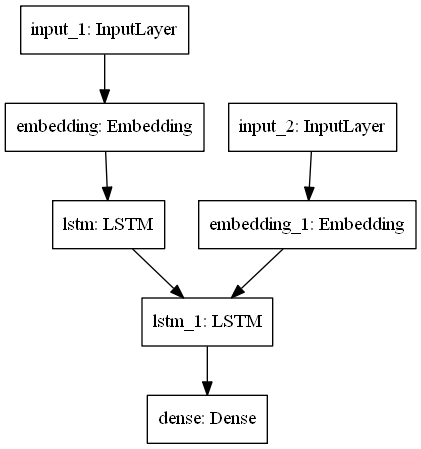

In [24]:
tf.keras.utils.plot_model(encoder_decoder_model)

Définir le modèle que l’on nommera `encoder_model` ayant:

- pour entrée la couche d’entrée de l’encodeur (Input),
- pour sortie la liste des états de l’encodeur (encoder_states)

In [25]:
with tf.device('/gpu:0'):
    encoder_model = Model(inputs = e_input, outputs = encoder_states)
encoder_model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 10, 256)           12385280  
_________________________________________________________________
lstm (LSTM)                  [(None, 256), (None, 256) 525312    
Total params: 12,910,592
Trainable params: 12,910,592
Non-trainable params: 0
_________________________________________________________________


**Définition du décodeur pour la prédiction**  
- Définir deux entrées de dimension 256 chacune pour les états h et c.
- Stocker ces états h et c dans une liste que l’on nommera `decoder_states_input`
- Indiquer que la couche LSTM prendra ici en entrée la sortie de la couche d’embedding du décodeur et pour états initiaux la liste `decoder_states_input`. La couche LSTM doit retourner les états que l’on stockera dans une liste.
- Appliquer la couche dense sur les sorties de la couche lstm ci-dessus.
- Définir le modèle `decodeur_model` ayant pour entrée la couche d’entrée de la partie décodeur et la liste des états et pour sortie la sortie de la couche dense obtenue au point précédent et les états de la couche LSTM.

In [26]:
d_state_h = layers.Input(shape = (256,))
d_state_c = layers.Input(shape = (256,))
decoder_state_input = [d_state_h, d_state_c]

d_lstm_out, d_state_h, d_state_c = d_lstm_layer(d_embed, initial_state = decoder_state_input)
decoder_states = [d_state_h, d_state_c]
decoder_outputs = d_dense_layer(d_lstm_out)

with tf.device('/gpu:0'):
    decoder_model = Model(
        inputs = [d_input] + decoder_state_input,
        outputs = [d_lstm_out] + decoder_states
    )

decoder_model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 10, 256)      8778496     input_2[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 256)]        0                                            
_______________________________________________________________________________________

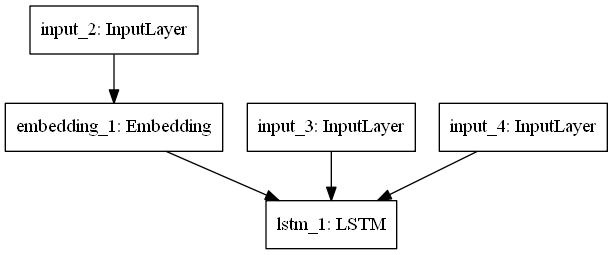

In [27]:
tf.keras.utils.plot_model(decoder_model)

## Apprentissage
Compiler le modèle `encoder_decoder` avec la fonction de coût **sparse_categorical_crossentropy** et l’optimisation des poids faite avec la méthode **Adam**.

In [28]:
encoder_decoder_model.compile(optimizer = 'adam', loss = sparse_categorical_crossentropy)

En utilisant la méthode `.fit`, entraîner le modèle sur 10 epochs avec des batchs de taille 32.  
Attention de bien renseigner les 2 entrées dans une liste (texte français et le texte anglais pour le décodeur).  
Il faut également donner la vérité terrain (texte anglais). On restreindra l’apprentissage à quelques exemples du jeu de données (par exemple 1024 phrases)

In [29]:
with tf.device('/gpu:0'):
    history = encoder_decoder_model.fit(
        [pad_tok_fr[:1024], pad_tok_en_d[:1024]], pad_tok_en[:1024],
        batch_size = 32,
        epochs = 10
    )

Epoch 1/10
32/32 [==============================] - 5s 162ms/step - loss: nan
Epoch 2/10
32/32 [==============================] - 5s 158ms/step - loss: nan
Epoch 3/10
32/32 [==============================] - 5s 158ms/step - loss: nan
Epoch 4/10
32/32 [==============================] - 5s 157ms/step - loss: nan
Epoch 5/10
32/32 [==============================] - 5s 158ms/step - loss: nan
Epoch 6/10
32/32 [==============================] - 5s 158ms/step - loss: nan
Epoch 7/10
32/32 [==============================] - 5s 158ms/step - loss: nan
Epoch 8/10
32/32 [==============================] - 5s 158ms/step - loss: nan
Epoch 9/10
32/32 [==============================] - 5s 158ms/step - loss: nan
Epoch 10/10
32/32 [==============================] - 5s 157ms/step - loss: nan


## Prédiction
Appliquer la fonction `decode_prediction` sur une phrase du jeu de données non vue en apprentissage.  
Afficher:

- la phrase en français
- la phrase en anglais (*vérité terrain*)
- la phrase prédite.

In [32]:
index_pred = -2
phrase_pred = decode_prediction(
    pad_tok_fr[index_pred:index_pred + 1],
    encoder_model,
    decoder_model,
    int2ch_en, MAX_LEN, len(vocab_en) + 1
)
print(phrase_pred)

(1, 10, 256)
1
resumption
(1, 10, 256)
1
resumption
(1, 10, 256)
1
resumption
(1, 10, 256)
1
resumption
(1, 10, 256)
1
resumption
(1, 10, 256)
1
resumption
(1, 10, 256)
1
resumption
(1, 10, 256)
1
resumption
(1, 10, 256)
1
resumption
(1, 10, 256)
1
resumption
resumption resumption resumption resumption resumption resumption resumption resumption resumption resumption 
